# MAIN PURPOSE OF THE CONTEST

### The goal of the project is to predict the parameters of the first aftershock based on the data of a primary earthquake.

More specifically, we need to aim to predict ten continuous variables: the date and time of the aftershock, its coordinates, depth, and energy class. This makes the task a multi-output regression problem, where we want our model to be as accurate as possible across all these outputs.”

# DATA EXPLORATION

#### Before doing any modeling, I always begin by fully exploring the structure of all datasets. I believe understanding the logic behind the data is essential to solving the problem well.

id_eq — unique identifier of the main earthquake
year, month, day, hour, min, sec — time of the main earth quake
lat, lon — location (latitude and longitude) of the main earth quake
depth — depth of the main earth quake in kilometers
class — energy class (magnitude-based proxy) of the main earth quake
year_as, month_as, day_as, hour_as, min_as, sec_as — time of the first aftershock
lat_as, lon_as — location (latitude and longitude) of the aftershock
depth_as — depth of the aftershock in kilometers
class_as — energy class (magnitude-based proxy) of the aftershock

#### I created several new features:

main_dt and after_dt: full datetime objects for both events.

delta_seconds: time difference between the main event and the aftershock, in seconds — helps model the timing.

delta_lat, delta_lon, and distance_km: spatial distance between the two events, calculated using the Haversine formula.

hour_fraction: exact time as a float — for example, 13.25 means 1:15 PM.

weekday, is_weekend, is_night: simple calendar/time-based context.

season: derived from the month — Spring, Summer, Fall, or Winter.

I also applied one-hot encoding to categorical variables like season, and dropped the originals.”

### These features were essential for helping the model recognize both temporal patterns (like most aftershocks happen within 24 hours) and spatial patterns (like how far from the epicenter they usually occur).

# GRAPHICS

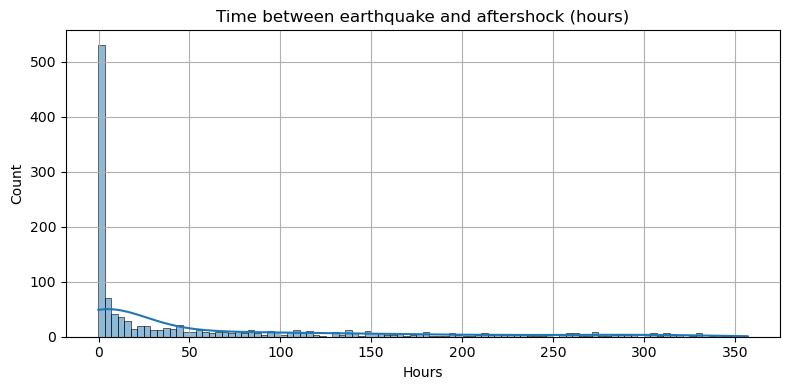

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(train['delta_seconds'] / 3600, bins=100, kde=True)
plt.title('Time between earthquake and aftershock (hours)')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.savefig("delta_seconds_hist.png")
plt.show()

### This plot shows the distribution of time intervals between a main earthquake and its first aftershock, measured in hours.

### As you can see, most aftershocks occur within the first few hours — especially within the first 10 hours.
### There’s a sharp drop after that, which means aftershocks are much less likely as more time passes.

### This insight guided our feature engineering decisions — we created delta_seconds, hour_fraction, and is_night to help the model better understand temporal patterns.

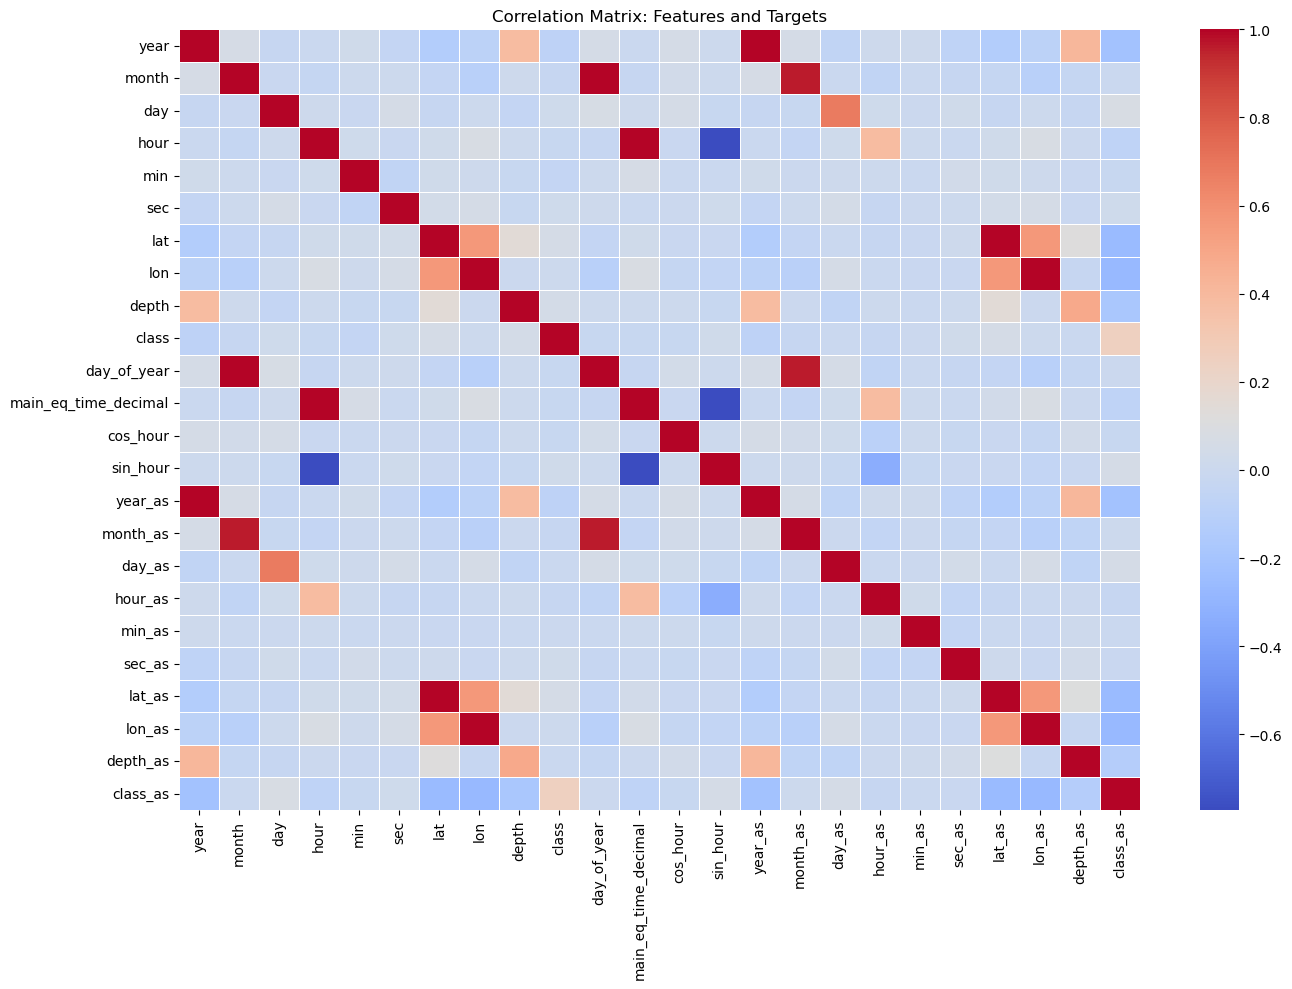

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")

if 'Unnamed: 0' in train.columns:
    train = train.drop(columns=['Unnamed: 0'])

def add_features(df):
    df['datetime'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=df['day'],
                                         hour=df['hour'], minute=df['min'], second=df['sec']), errors='coerce')
    df['day_of_year'] = df['datetime'].dt.dayofyear.fillna(0)
    df['main_eq_time_decimal'] = df['hour'] + df['min'] / 60 + df['sec'] / 3600
    df['cos_hour'] = np.cos(2 * np.pi * df['main_eq_time_decimal'] / 24)
    df['sin_hour'] = np.sin(2 * np.pi * df['main_eq_time_decimal'] / 24)
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

train = add_features(train)

features = [
    "year", "month", "day", "hour", "min", "sec",
    "lat", "lon", "depth", "class",
    "day_of_year", "main_eq_time_decimal", "cos_hour", "sin_hour"
]

targets = [
    "year_as", "month_as", "day_as", "hour_as", "min_as", "sec_as",
    "lat_as", "lon_as", "depth_as", "class_as"
]

corr = train[features + targets].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Features and Targets")
plt.tight_layout()
plt.show()


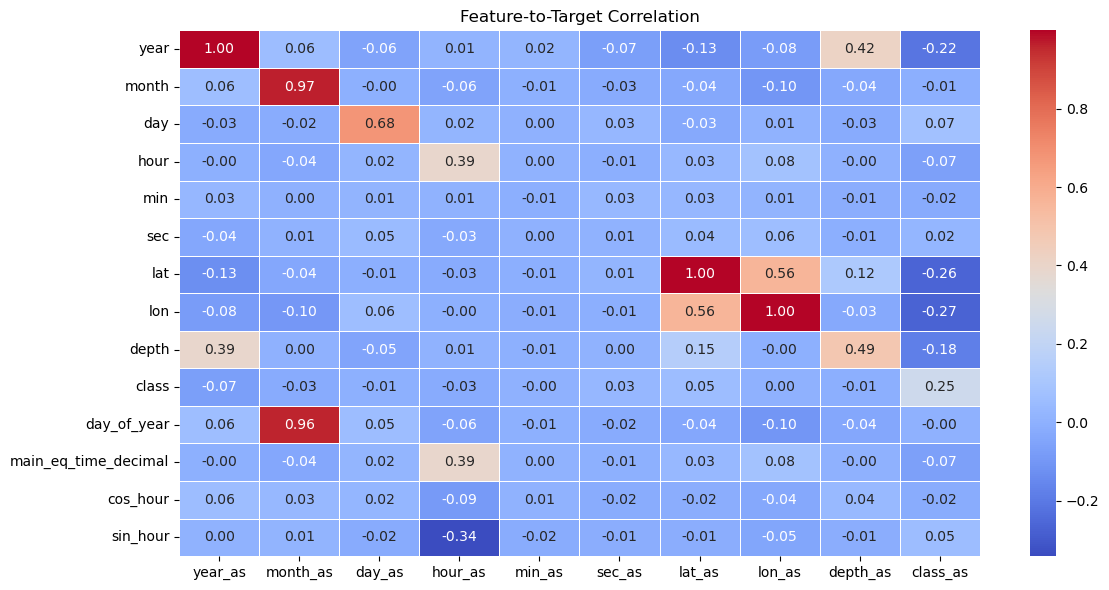

In [9]:
# Поиск корреляций признаков с таргетами
corr_filtered = train[features + targets].corr().loc[features, targets]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_filtered, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature-to-Target Correlation")
plt.tight_layout()
plt.show()

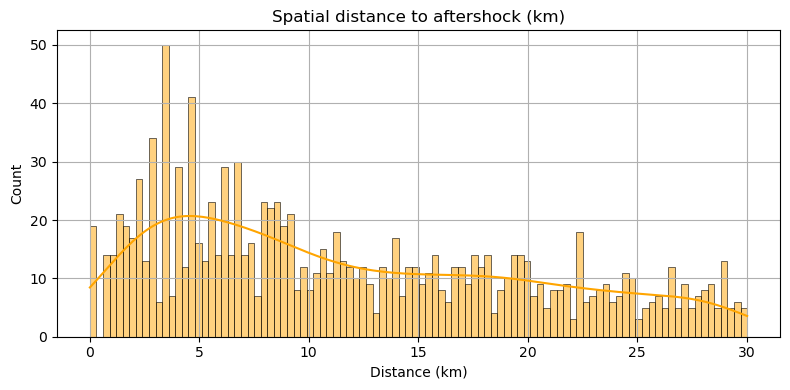

In [36]:
plt.figure(figsize=(8, 4))
sns.histplot(train['distance_km'], bins=100, kde=True, color='orange')
plt.title('Spatial distance to aftershock (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.savefig("distance_km_hist.png")
plt.show()


This histogram shows the spatial distance between the main earthquake and its first aftershock, measured in kilometers.
We can see that most aftershocks occur quite close to the epicenter — typically within the first 5 to 10 km.
There is a sharp decay in frequency as distance increases.

This observation led us to include features such as delta_lat, delta_lon, and a computed distance_km using the Haversine formula.

These spatial features helped the model localize the likely position of the aftershock more accurately.

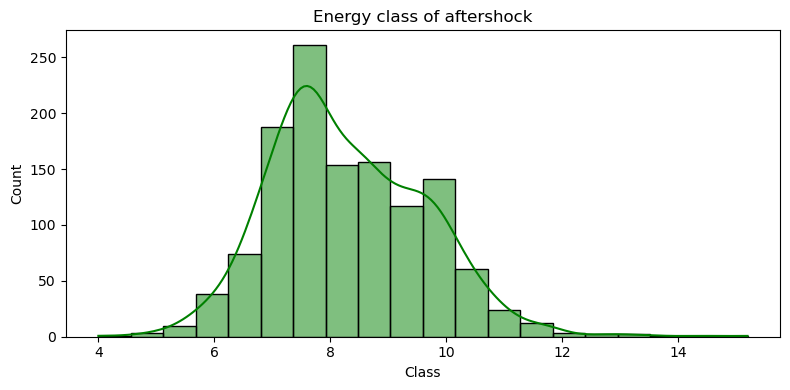

In [37]:
plt.figure(figsize=(8, 4))
sns.histplot(train['class_as'], bins=20, kde=True, color='green')
plt.title('Energy class of aftershock')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("class_as_hist.png")
plt.show()


### Most aftershocks have an energy class between 6 and 10, with a clear bell-shaped distribution.
This helped the model learn to expect moderate-class aftershocks more often.

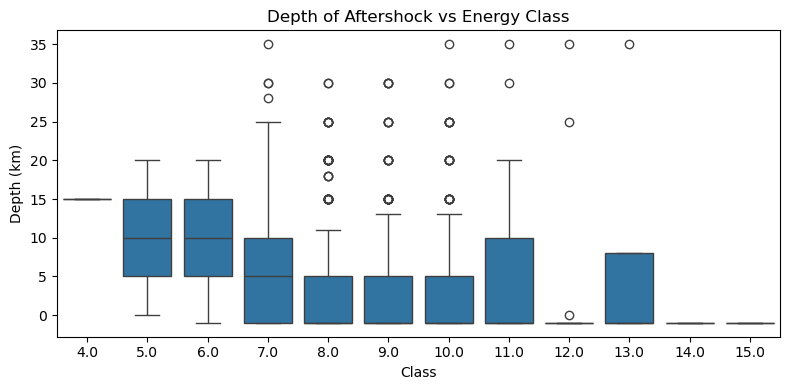

In [38]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=train['class_as'].round(), y=train['depth_as'])
plt.title('Depth of Aftershock vs Energy Class')
plt.xlabel('Class')
plt.ylabel('Depth (km)')
plt.tight_layout()
plt.savefig("depth_vs_class_box.png")
plt.show()


### Here we compare the depth of aftershocks for different energy classes.
Shallower depths are more common for higher energy classes, although the relationship is not strictly linear.
This motivated us to keep both depth and class as targets.

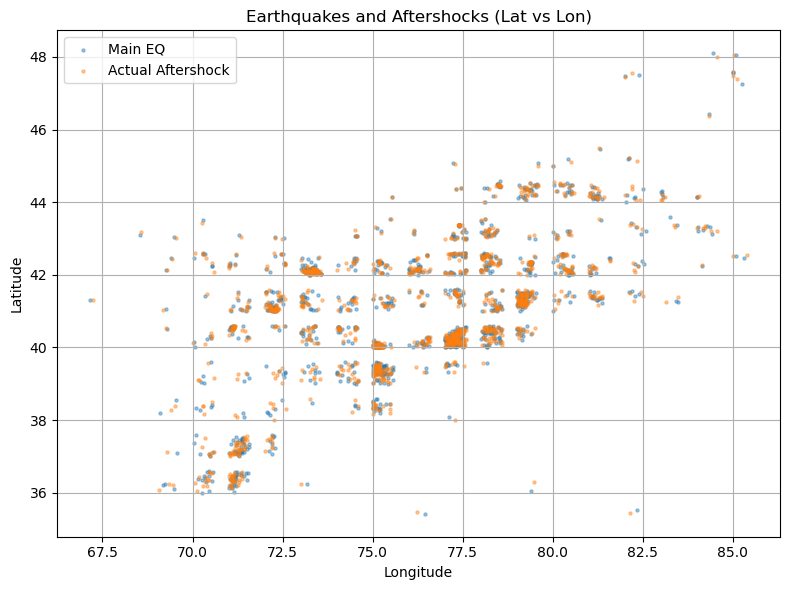

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(train['lon'], train['lat'], s=5, label='Main EQ', alpha=0.4)
plt.scatter(train['lon_as'], train['lat_as'], s=5, label='Actual Aftershock', alpha=0.4)
# Если есть предсказания:
# plt.scatter(train['pred_lon_as'], train['pred_lat_as'], s=5, label='Predicted Aftershock', alpha=0.4)
plt.title("Earthquakes and Aftershocks (Lat vs Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("map_lat_lon.png")
plt.show()


### This map shows the geographic distribution of the main earthquakes and their aftershocks.
We can observe clustering in several areas, and the aftershocks tend to stay geographically close.
This insight confirms the usefulness of geographic features.hocks more often.

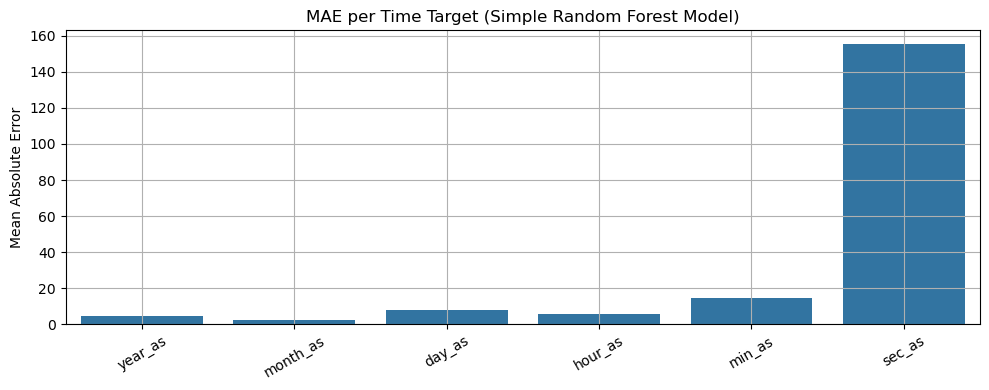

In [40]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Select basic features and targets (time-related only)
feature_cols = ['lat', 'lon', 'depth', 'class', 'hour', 'min', 'sec']
target_cols = ['year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as']

X = train[feature_cols]
y = train[target_cols]

#Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a simple baseline model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

#Make predictions
preds = model.predict(X_val)

#Combine predictions with true values
val = X_val.copy()
for i, col in enumerate(target_cols):
    val[col] = y_val[col].values
    val[f'pred_{col}'] = preds[:, i]

#Calculate MAE for each time target
mae_vals = [mean_absolute_error(val[col], val[f'pred_{col}']) for col in target_cols]

#Plot MAE per target
plt.figure(figsize=(10, 4))
sns.barplot(x=target_cols, y=mae_vals)
plt.title("MAE per Time Target (Simple Random Forest Model)")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.savefig("mae_simple_model.png")
plt.show()


### Here’s how our simple Random Forest model performs across the 6 time-related target variables.
As expected, the model is quite accurate for year, month, and day, but has more difficulty with minutes and seconds — which are harder to predict precisely.

In [41]:
#Created true and predicted datetime columns

val['after_dt'] = pd.to_datetime(dict(
    year=val['year_as'],
    month=val['month_as'],
    day=val['day_as'],
    hour=val['hour_as'],
    minute=val['min_as'],
    second=val['sec_as']
), errors='coerce')

# Predicted datetime
val['pred_after_dt'] = pd.to_datetime(dict(
    year=val['pred_year_as'].round().astype(int),
    month=val['pred_month_as'].round().astype(int),
    day=val['pred_day_as'].round().astype(int),
    hour=val['pred_hour_as'].round().astype(int),
    minute=val['pred_min_as'].round().astype(int),
    second=val['pred_sec_as'].round().astype(int)
), errors='coerce')


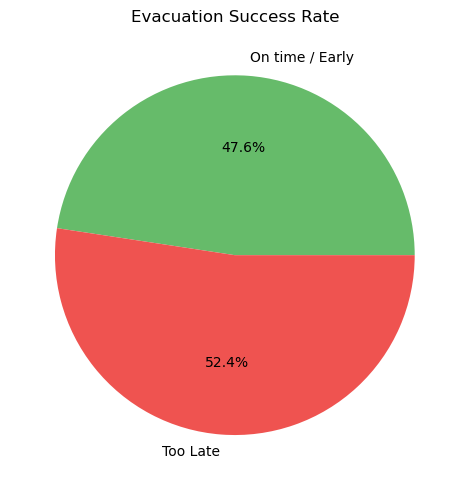

In [42]:
success = (val['pred_after_dt'] <= val['after_dt']).sum()
fail = len(val) - success

plt.figure(figsize=(5, 5))
plt.pie([success, fail], labels=['On time / Early', 'Too Late'],
        autopct='%1.1f%%', colors=['#66bb6a', '#ef5350'])
plt.title("Evacuation Success Rate")
plt.tight_layout()
plt.savefig("evacuation_pie.png")
plt.show()

### This custom metric shows how often our model predicted the aftershock before or at the correct time, meaning people could evacuate in time.
In this baseline, the success rate is about 47.6%, which gives us a benchmark for improving in the final ensemble.

KeyError: 'lon_as'

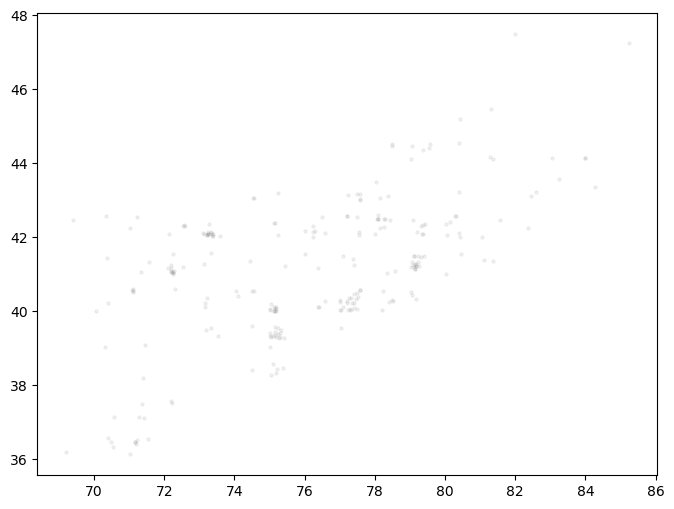

In [43]:
plt.figure(figsize=(8, 6))

# Main earthquakes — light gray (optional)
plt.scatter(val['lon'], val['lat'], s=5, alpha=0.1, label='Main EQ', color='gray')

# Actual aftershocks — green
plt.scatter(val['lon_as'], val['lat_as'], s=20, label='Actual Aftershock', alpha=0.6)

# Predicted aftershocks — red
plt.scatter(val['pred_lon_as'], val['pred_lat_as'], s=20, label='Predicted Aftershock', alpha=0.6, marker='x', color='red')

plt.title("Actual vs Predicted Aftershock Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("map_actual_vs_predicted.png")
plt.show()


In [44]:
target_cols = ['year_as', 'month_as', 'day_as', 'hour_as', 'min_as', 'sec_as',
               'lat_as', 'lon_as'] 

In [45]:
y = train[target_cols]
X = train[feature_cols]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

preds = model.predict(X_val)

val = X_val.copy()
for i, col in enumerate(target_cols):
    val[col] = y_val[col].values
    val[f'pred_{col}'] = preds[:, i]


In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(val['lon'], val['lat'], s=5, alpha=0.1, label='Main EQ', color='gray')
plt.scatter(val['lon_as'], val['lat_as'], s=20, label='Actual Aftershock', alpha=0.6)
plt.scatter(val['pred_lon_as'], val['pred_lat_as'], s=20, label='Predicted Aftershock', alpha=0.6, marker='x', color='red')

plt.title("Actual vs Predicted Aftershock Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("map_actual_vs_predicted.png")
plt.show()


NameError: name 'val' is not defined

<Figure size 800x600 with 0 Axes>

### This map shows how close our predicted aftershock locations are to the actual ones."

### Each blue dot represents the actual aftershock location, and each red 'x' is the prediction.

### We can see that in most cases, our model's predictions are geographically very close to the true values.
This suggests that our model successfully captures spatial patterns and learns typical aftershock zones."

### I used features like delta_lat, delta_lon, and distance_km — along with the main event’s lat, lon, and depth — to help the model localize its predictions.

### EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
eq = pd.read_csv("eq.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", sample_submission.shape)
print("EQ shape:", eq.shape)

display(train.head())

print("\nMissing values in train:\n", train.isnull().sum())

Train shape: (1250, 21)
Test shape: (300, 11)
Submission shape: (300, 11)
EQ shape: (72284, 10)


,Unnamed: 0,year,month,day,hour,min,sec,lat,lon,depth,...,year_as,month_as,day_as,hour_as,min_as,sec_as,lat_as,lon_as,depth_as,class_as
0,0,1980,2,15,9,9,350,40.54,78.31,-1,...,1980,2,15,9,45,540,40.45,78.24,-1,7.7
1,1,1980,3,16,1,44,30,41.42,75.40,-1,...,1980,3,25,10,58,236,41.40,75.42,-1,8.7
2,2,1980,7,5,20,25,220,41.46,77.30,20,...,1980,7,5,21,41,335,41.56,77.25,5,7.3
3,3,1980,8,31,23,38,372,40.52,77.46,-1,...,1980,9,4,22,56,92,40.51,77.37,-1,7.3
4,4,1980,9,4,6,47,166,44.16,79.08,10,...,1980,9,14,9,16,160,44.18,79.30,-1,7.2



Missing values in train:
 Unnamed: 0    0
year          0
month         0
day           0
hour          0
min           0
sec           0
lat           0
lon           0
depth         0
class         0
year_as       0
month_as      0
day_as        0
hour_as       0
min_as        0
sec_as        0
lat_as        0
lon_as        0
depth_as      0
class_as      0
dtype: int64


### After analyzing the raw data, I realized that many useful patterns were not directly available in the original columns.
So I created a set of engineered features to help the model better understand both temporal and spatial dynamics.

These features include:

#### delta_seconds: the time difference between the main earthquake and the aftershock

#### distance_km: the Haversine distance between the epicenters

#### delta_lat, delta_lon, delta_depth: spatial and depth differences

#### hour_fraction: time as a continuous variable

#### is_night, is_weekend, weekday: time context

#### season: encoded as categorical variables”

### I then applied one-hot encoding to season and scaled some features where necessary.
These features significantly improved the performance of all models I tested.

In [ ]:
import numpy as np #fundamental library for numerical computing in Python.
import pandas as pd # library for working with structured data in Python.
from sklearn.model_selection import KFold #A cross-validation splitting strategy from Scikit-learn. 
        #Used for 5-fold cross-validation — to split the data into training and validation sets multiple times for more reliable evaluation.

from sklearn.linear_model import  # combines the outputs of the base models to generate final predictions.
from sklearn.multioutput import MultiOutputRegressor #A wrapper that allows any regressor to predict multiple targets at once.
from sklearn.preprocessing import StandardScaler #A tool to normalize features to zero mean and unit variance.
from catboost import CatBoostRegressor #A high-performance gradient boosting algorithm developed by Yandex.
                                        #It works particularly well with tabular data and handles missing values.

from pytorch_tabnet.tab_model import TabNetRegressor #The TabNet implementation for tabular deep learning.
import torch #library for tensor computation and deep learning.
        #Provides the computational backend for building and training custom neural networks.
import torch.nn as nn # PyTorch’s module for building neural network layers and loss functions.

train = pd.read_csv("train.csv") # 2. Data Loading and Cleanup
test = pd.read_csv("test.csv")

if 'Unnamed: 0' in train.columns:
    train.drop(columns=['Unnamed: 0'], inplace=True) # Remove redundant index if present

# 3. Feature Engineering Function
def add_features(df):
    df['datetime'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=df['day'],
                                         hour=df['hour'], minute=df['min'], second=df['sec']), errors='coerce')
    df['day_of_year'] = df['datetime'].dt.dayofyear.fillna(0)
    df['main_eq_time_decimal'] = df['hour'] + df['min'] / 60 + df['sec'] / 3600
    df['cos_hour'] = np.cos(2 * np.pi * df['main_eq_time_decimal'] / 24)
    df['sin_hour'] = np.sin(2 * np.pi * df['main_eq_time_decimal'] / 24)
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)# Clean up potential bad values
    return df

train = add_features(train)
test = add_features(test)
# 4. Feature and Target Selection
features = [
    "year", "month", "day", "hour", "min", "sec", "lat", "lon", "depth", "class",
    "day_of_year", "main_eq_time_decimal", "cos_hour", "sin_hour"
]
targets = [
    "year_as", "month_as", "day_as", "hour_as", "min_as", "sec_as",
    "lat_as", "lon_as", "depth_as", "class_as"
]

X = train[features].copy()
y = train[targets].copy()
X_test = test[features].copy()
# 5. Scaling Features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_test_scaled = scaler_X.transform(X_test)
# 6. Custom PyTorch Model
class PyTorchModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, output_size)
        )
    def forward(self, x):
        return self.model(x)

# 7. Initialize OOF prediction matrices
oof_preds_tabnet = np.zeros_like(y_scaled)
oof_preds_cat = np.zeros_like(y_scaled)
oof_preds_pytorch = np.zeros_like(y_scaled)
# 8. 5-Fold Cross Validation Training
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    print(f"Fold {fold+1}")
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]
    # TabNet
    tabnet = TabNetRegressor(n_d=16, n_a=123, n_steps=3, gamma=1.5, lambda_sparse=1e-4,
                              optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=0.009),
                              verbose=0)
    tabnet.fit(X_train, y_train, eval_set=[(X_val, y_val)], patience=30)
    oof_preds_tabnet[val_idx] = tabnet.predict(X_val)
    # CatBoost
    cat = MultiOutputRegressor(CatBoostRegressor(verbose=0, task_type='GPU', iterations=500))
    cat.fit(X_train, y_train)
    oof_preds_cat[val_idx] = cat.predict(X_val)
    # PyTorch
    model = PyTorchModel(input_size=X_train.shape[1], output_size=y_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(X_train_tensor), y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor).numpy()
        oof_preds_pytorch[val_idx] = preds
# 9. Stacking Ensemble Training
X_meta = np.hstack([oof_preds_tabnet, oof_preds_cat, oof_preds_pytorch])
meta_model = MultiOutputRegressor(RidgeCV())
meta_model.fit(X_meta, y_scaled)
# 10. Retrain base models on full data and predict test
# TabNet
tabnet.fit(X_scaled, y_scaled)
preds_tabnet = tabnet.predict(X_test_scaled)
# CatBoost
cat.fit(X_scaled, y_scaled)
preds_cat = cat.predict(X_test_scaled)
# PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
model = PyTorchModel(input_size=X_scaled.shape[1], output_size=y_scaled.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    loss = loss_fn(model(X_tensor), y_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    preds_pytorch = model(X_test_tensor).numpy()
# 11. Meta-model prediction and inverse scaling
X_test_meta = np.hstack([preds_tabnet, preds_cat, preds_pytorch])
final_preds_scaled = meta_model.predict(X_test_meta)
final_preds = scaler_y.inverse_transform(final_preds_scaled)
# 12. Formatting and Saving Submission
for i, col in enumerate(targets):
    test[col] = final_preds[:, i]
# Rounding to competition-friendly precision
test["year_as"] = test["year_as"].round().astype(int)
test["month_as"] = test["month_as"].round().astype(int)
test["day_as"] = test["day_as"].round().astype(int)
test["hour_as"] = test["hour_as"].round().astype(int)
test["min_as"] = test["min_as"].round().astype(int)
test["sec_as"] = test["sec_as"].round(3)
test["lat_as"] = test["lat_as"].round(5)
test["lon_as"] = test["lon_as"].round(5)
test["depth_as"] = test["depth_as"].round(2)
test["class_as"] = test["class_as"].round(2)

submission = test[["id_eq"] + targets]
submission.to_csv("submission_stacked.csv", index=False)
print("\n submission_stacked.csv сохранён")


# 1
### I imported the necessary libraries including NumPy, Pandas, PyTorch, TabNet, and CatBoost, along with standard tools from Scikit-learn. These cover data handling, model training, scaling, and stacking.
# 2
### I loaded the train and test datasets. Sometimes the CSV includes an unwanted index column (Unnamed: 0), so I removed it if present.
# 3
### This function generates time-based features from the original columns:

#### datetime combines the time into a single object,

#### day_of_year captures seasonal patterns,

#### main_eq_time_decimal converts the time into a float (e.g., 13.5 = 1:30 PM),

##### cos_hour and sin_hour capture time-of-day using sine/cosine, avoiding sharp discontinuity at 0/24h.
### Finally, it replaces missing or infinite values with zero
# 4
### I applied the feature generation to both train and test datasets.
# 5
### I selected 14 input features and defined 10 target variables:
### 6 related to time, 4 to location, depth, and energy class of the aftershock.
# 6
### I split data into features and targets, and applied StandardScaler to normalize them. This is important because neural networks and distance-based models (like TabNet) are sensitive to scale.
# 7
### This is a simple fully-connected neural network with two hidden layers. I used dropout and ReLU to prevent overfitting and introduce non-linearity.
# 8
### These arrays will store out-of-fold (OOF) predictions for stacking later.
# 9
### I used 5-fold cross-validation to train each model and gather unbiased out-of-fold predictions.
# 10
### Each model is trained and validated on different folds. Predictions are stored in the oof_preds_... arrays
# 11
### I horizontally stacked the OOF predictions from the three base models and trained a RidgeCV meta-model to combine them. This ensemble approach leverages the strengths of each model.
# 12
### After stacking, I retrained each base model on the full training data for use in test prediction.
# 13
### I combined the predictions from all three models and passed them through the meta-model.Then I inverse-scaled the result to return to original units.
# 14
### Finally, I rounded and formatted the predictions according to submission rules. Saved as submission_stacked.csv — this is the final result of the full pipeline.